In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from sklearn.model_selection import train_test_split

import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# own utils # TODO resolve namespace pollution by restricitn g importis in init
from utils.configuration import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.loss_continous import *
from utils.sampling_tram_data import *

Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "tramdag_paper_test_std"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Loaded existing configuration from /home/bule/TramDag/dev_experiment_logs/tramdag_paper_test_std/configuration.json


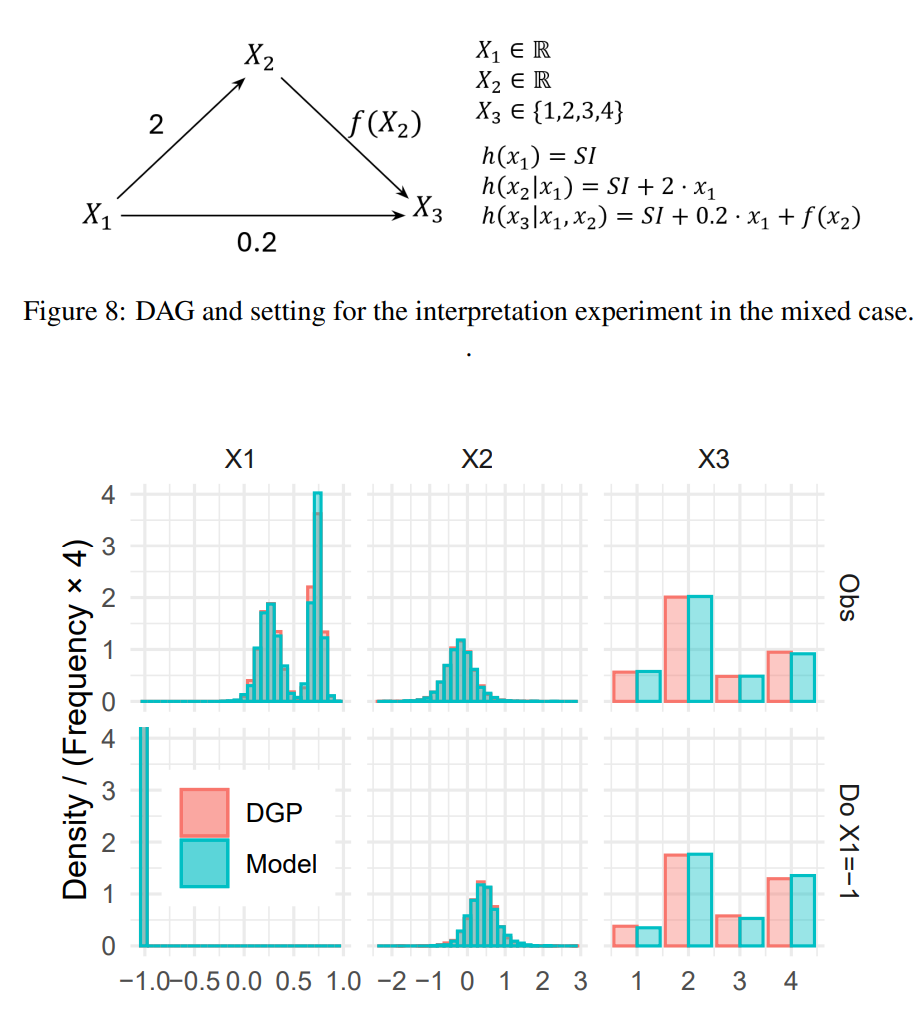

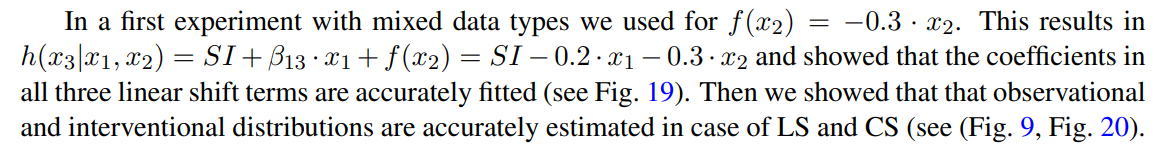

# 2.  Data

Loaded data from /home/bule/TramDag/dev_experiment_logs/tramdag_paper_test_std/tramdag_paper_test_std.csv
Variable 'x1' is modeled as a continuous variable. for target and predictor.
Variable 'x2' is modeled as a continuous variable. for target and predictor.
Variable 'x3' is modeled as an ordinal   variable. As PREDICTOR: OneHot and TARGET: OneHot.
Configuration updated successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x1      100000 non-null  float64
 1   x2      100000 non-null  float64
 2   x3      100000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.3 MB


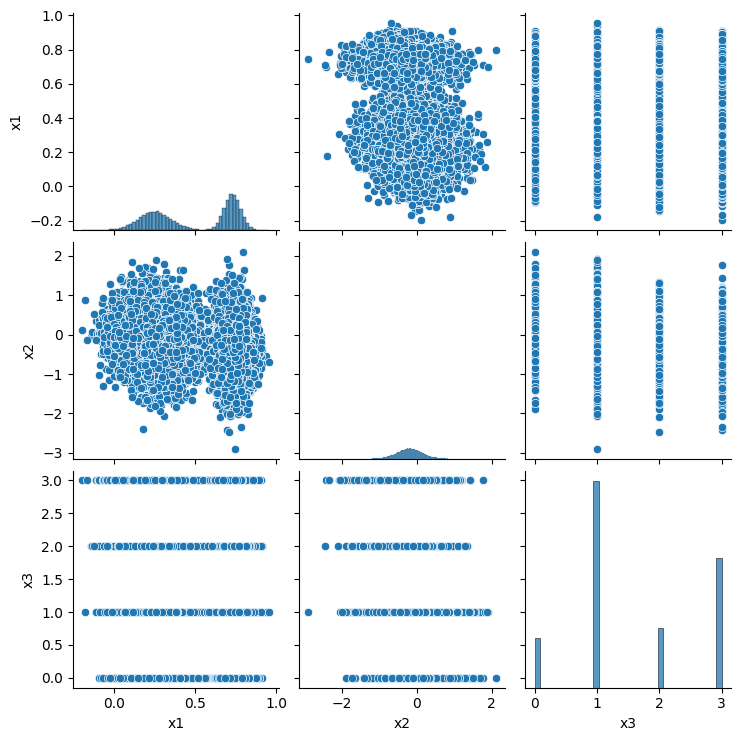

In [3]:
def dgp(n_obs, doX=[None, None, None], f=lambda x: x, seed=None):
    """
    Data-generating process matching the provided R implementation.
    
    Parameters
    ----------
    n_obs : int
        Number of observations to generate.
    doX : list of length 3
        If doX[i] is not None, fixes X_{i+1} to that constant for all draws.
    f : callable
        A function of X2 used in generating X3 (defaults to identity).
    seed : int or None
        If provided, sets the NumPy random seed.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['x1', 'x2', 'x3'], where x3 is an ordered
        categorical with levels 1 < 2 < 3 < 4.
    """
    if seed is not None:
        np.random.seed(seed)
        print(f"Setting seed: {seed}")

    # --- 1. Sample X1 from a 2-component GMM ---
    if doX[0] is None:
        X1_A = np.random.normal(loc=0.25, scale=0.10, size=n_obs)
        X1_B = np.random.normal(loc=0.73, scale=0.05, size=n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, X1_A, X1_B)
    else:
        x1 = np.full(n_obs, doX[0], dtype=float)

    # --- 2. Sample X2 via shifted-logit inversion (as in R) ---
    if doX[1] is None:
        # draw U2 ~ Uniform(0,1) and map through quantile of logistic
        u2 = np.random.uniform(size=n_obs)
        z2 = np.log(u2 / (1 - u2))  # qlogis
        # replicate: X2 = (z2 - 2 * x1) / 5
        x2 = (z2 - 2 * x1) / 5.0
    else:
        x2 = np.full(n_obs, doX[1], dtype=float)

    # --- 3. Sample X3 as an ordinal via logistic thresholds ---
    if doX[2] is None:
        # latent U3 ~ Logistic(0,1)
        u3 = np.random.logistic(loc=0.0, scale=1.0, size=n_obs)
        # thresholds theta_k = (-2, 0.42, 1.02)
        theta = np.array([-2.0, 0.42, 1.02])
        # compute h[i,k] = theta_k + 0.2 * x1[i] + f(x2[i])
        h = theta + 0.2 * x1.reshape(-1, 1) + f(x2).reshape(-1, 1)
        # assign x3 starting at 0
        x3 = np.zeros(n_obs, dtype=int)
        x3[u3 > h[:, 0]] = 1
        x3[u3 > h[:, 1]] = 2
        x3[u3 > h[:, 2]] = 3
        # convert to ordered categorical
        x3 = pd.Categorical(x3, categories=[0, 1, 2, 3], ordered=True)
    else:
        x3 = pd.Categorical(
            np.full(n_obs, doX[2], dtype=int),
            categories=[0, 1, 2, 3],
            ordered=True
        )
        
    # x3 = x3.astype(float) / 4.0
    x3 = x3.astype(int) 
    return pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})



EXP_DATA_PATH=os.path.join(DATA_PATH, f"{experiment_name}.csv")
if not os.path.exists(EXP_DATA_PATH):
    df = dgp(n_obs=100000, seed=42)
    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")

sns.pairplot(df)

data_type= {'x1':'continous','x2':'continous','x3':'ordinal_Xn_Yo'} 

write_data_type_to_configuration(data_type, CONF_DICT_PATH)

df.info()

## 2.1 train test split

In [4]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

# # 3. Normalize all sets using training quantiles
# def normalize_with_quantiles(df, min_vals, max_vals):
#     return (df - min_vals) / (max_vals - min_vals)


def normalize_with_quantiles(df, min_vals, max_vals, exclude_columns=None):
    """
    Normalize df using (df - min) / (max - min), but skip any columns in exclude_columns.
    min_vals and max_vals should come from the training set.
    """
    exclude_columns = set() if exclude_columns is None else set(exclude_columns)
    normalized = df.copy()

    for col in df.columns:
        if col in exclude_columns:
            continue
        if col not in min_vals.index or col not in max_vals.index:
            continue
        min_val = min_vals[col]
        max_val = max_vals[col]
        range_ = max_val - min_val
        if range_ == 0 or pd.isna(range_):
            normalized[col] = df[col].apply(lambda x: 0.0 if not pd.isna(x) else x)
        else:
            normalized[col] = (df[col] - min_val) / range_
    return normalized



train_df = normalize_with_quantiles(train_df, min_vals, max_vals,exclude_columns=['x3'])
val_df = normalize_with_quantiles(val_df, min_vals, max_vals,exclude_columns=['x3'])
test_df = normalize_with_quantiles(test_df, min_vals, max_vals,exclude_columns=['x3'])

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 80000, Validation size: 10000, Test size: 10000


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


/home/bule/TramDag/utils/configuration.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


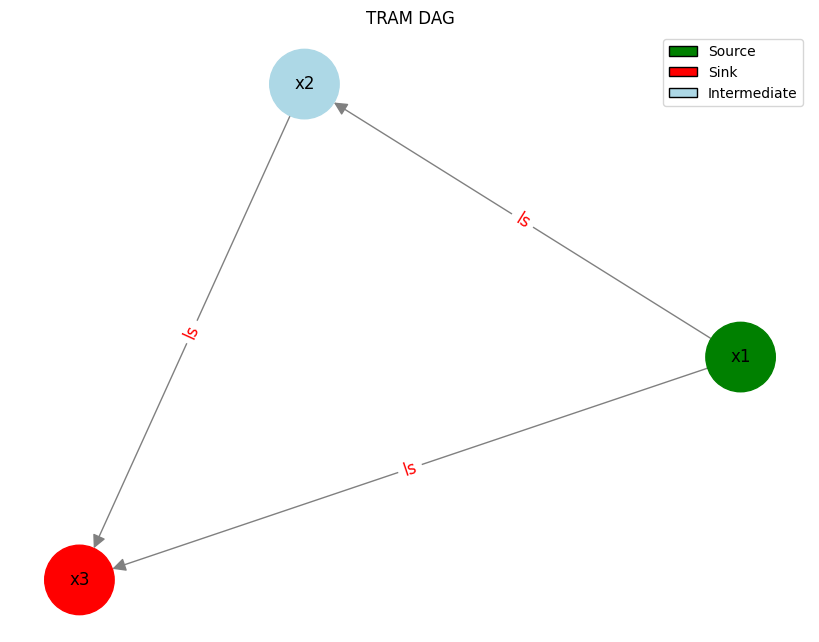

In [5]:
interactive_adj_matrix(CONF_DICT_PATH,seed=10)

# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

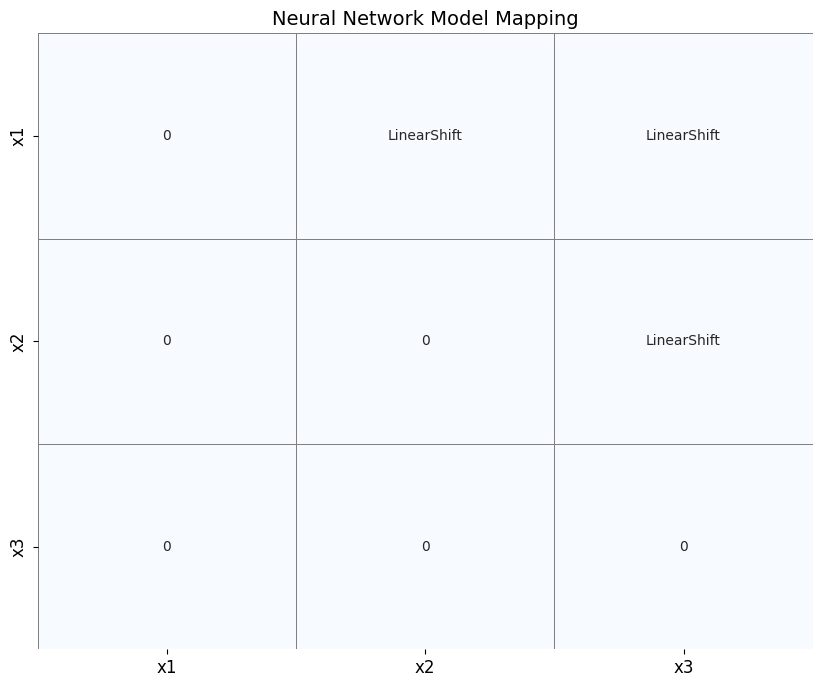

In [6]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [7]:
levels_dict=create_levels_dict(df,data_type)

write_nodes_information_to_configuration(CONF_DICT_PATH, min_vals, max_vals,levels_dict)

{'x1': {'Modelnr': 0, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.12157964485414735, 'max': 0.794303998711493, 'transformation_term_nn_models_in_h()': {}}, 'x2': {'Modelnr': 1, 'data_type': 'continous', 'node_type': 'internal', 'parents': ['x1'], 'parents_datatype': {'x1': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls')}, 'min': -0.8069206639187695, 'max': 0.418925659248077, 'transformation_term_nn_models_in_h()': {'x1': np.str_('LinearShift')}}, 'x3': {'Modelnr': 2, 'data_type': 'ordinal_Xn_Yo', 'levels': 4, 'node_type': 'sink', 'parents': ['x1', 'x2'], 'parents_datatype': {'x1': 'continous', 'x2': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls'), 'x2': np.str_('ls')}, 'min': 0.0, 'max': 3.0, 'transformation_term_nn_models_in_h()': {'x1': np.str_('LinearShift'), 'x2': np.str_('LinearShift')}}}
Configuration updated successfully.


### --------------------- 

In [8]:
train_list=['x1','x2','x3']#['x2']#'x1','x2']#,'x3']#['x1']#['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 512#4112
epochs = 500# <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
learning_rate=0.01
use_scheduler =  False

In [9]:
# For each NODE 
configuration_dict = load_configuration_dict(CONF_DICT_PATH)
target_nodes = configuration_dict['nodes'] ## TODO rename target nodes to nodelist 

for node in target_nodes:
    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')
    ########################## 0. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (target_nodes[node]['node_type'] == 'source') and (target_nodes[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 1. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    
    # Check if training is complete
    if not check_if_training_complete(node, NODE_DIR, epochs):
        continue
    
    ########################## 2. Create Model ##############################
    tram_model= get_fully_specified_tram_model(node, target_nodes, verbose=True)

    ########################## 3. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, target_nodes, train_df, val_df, batch_size=batch_size,return_intercept_shift=True, verbose=False)

    ########################## 5. Optimizer & Scheduler ######################.
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 7. Training Loop ##############################
    
    train_val_loop(
                node,
                target_nodes,
                NODE_DIR,
                tram_model,
                train_loader,
                val_loader,
                epochs,
                optimizer,
                use_scheduler,
                scheduler,
                save_linear_shifts=False,
                verbose=1,
                device=device) # TODO startvalues for bernsteinpols



----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
Node x1 already trained for 500 epochs. Skipping.

----*----------*-------------*--------------- Node: x2 ------------*-----------------*-------------------*--
Node x2 already trained for 500 epochs. Skipping.

----*----------*-------------*--------------- Node: x3 ------------*-----------------*-------------------*--
Node x3 already trained for 500 epochs. Skipping.


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 75220 to 15795
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      80000 non-null  float64
 1   x2      80000 non-null  float64
 2   x3      80000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.4 MB


In [11]:
_, val_loader = get_dataloader(node, target_nodes, train_df, val_df, batch_size=20,return_intercept_shift=True, verbose=False)

with torch.no_grad():
    for (int_input, shift_list), y in val_loader:
        int_input = int_input.to(device)
        shift_list = [s.to(device) for s in shift_list]
        y = y.to(device)
        y_pred = tram_model(int_input=int_input, shift_input=shift_list)
        if 'yo' in target_nodes[node]['data_type'].lower():
            loss = ontram_nll(y_pred, y)
            
        break

NameError: name 'tram_model' is not defined

In [ ]:
print(y)

In [ ]:
print(int_input)

In [ ]:
print(shift_list)

In [ ]:
y_pred

In [ ]:
pdf = get_pdf_ordinal(get_cdf_ordinal(y_pred))
print(pdf[:10])


In [ ]:
import matplotlib.pyplot as plt

pdf = get_pdf_ordinal(get_cdf_ordinal(y_pred)).cpu().numpy()

for i in range(30):
    plt.bar(range(pdf.shape[1]), pdf[i])
    plt.title(f"Sample {i}")
    plt.show()

In [ ]:
def transform_intercepts_ordinal(int_in):
    # get batch size
    bs = int_in.shape[0]

    # Initialize class 0 and K as constants (on same device as input)
    int0 = torch.full((bs, 1), -float('inf'), device=int_in.device)
    intK = torch.full((bs, 1), float('inf'), device=int_in.device)

    # Reshape to match the batch size
    int1 = int_in[:, 0].reshape(bs, 1)

    # Exponentiate and accumulate the values for the transformation
    intk = torch.cumsum(torch.exp(int_in[:, 1:]), dim=1)
    # intk = torch.cumsum(torch.square(int_in[:, 1:]), dim=1)

    # Concatenate intercepts along the second axis (columns)
    int_out = torch.cat([int0, int1, int1 + intk, intK], dim=1)

    return int_out



def get_cdf_ordinal(outputs):
    """"
    Get cumulative distribution function
    
    Args:
        outputs: output of a model of class OntramModel
    """
    int_in = outputs['int_out']
    shift_in = outputs['shift_out']
    
    # transform intercepts
    int = transform_intercepts_ordinal(int_in)

    if shift_in is not None:
        shift = torch.stack(shift_in, dim=1).sum(dim=1)    
        cdf = torch.sigmoid(torch.sub(int, shift))
    else:
        cdf = torch.sigmoid(int)
    return cdf

def get_pdf_ordinal(cdf):
    """"
    Get probability density function
    
    Args:
        cdf: cumulative distirbution function returning from get_cdf
    """
    return torch.sub(cdf[:,1:], cdf[:,:-1])




pred_labels = get_pdf_ordinal(get_cdf_ordinal(y_pred)).argmax(dim=1)
pred_labels

In [ ]:
#  Data transfer : 0.02s
#     Forward pass  : 0.03s
#     Loss compute  : 1.06s
#     Backward pass : 0.63s
#     Optimizer step: 0.07s
#     Validation    : 0.35s
#     Saving/checks : 0.00s
#     Total epoch   : 2.44s

# 6 Inspect Training

## 6.1 Loss vs epochs

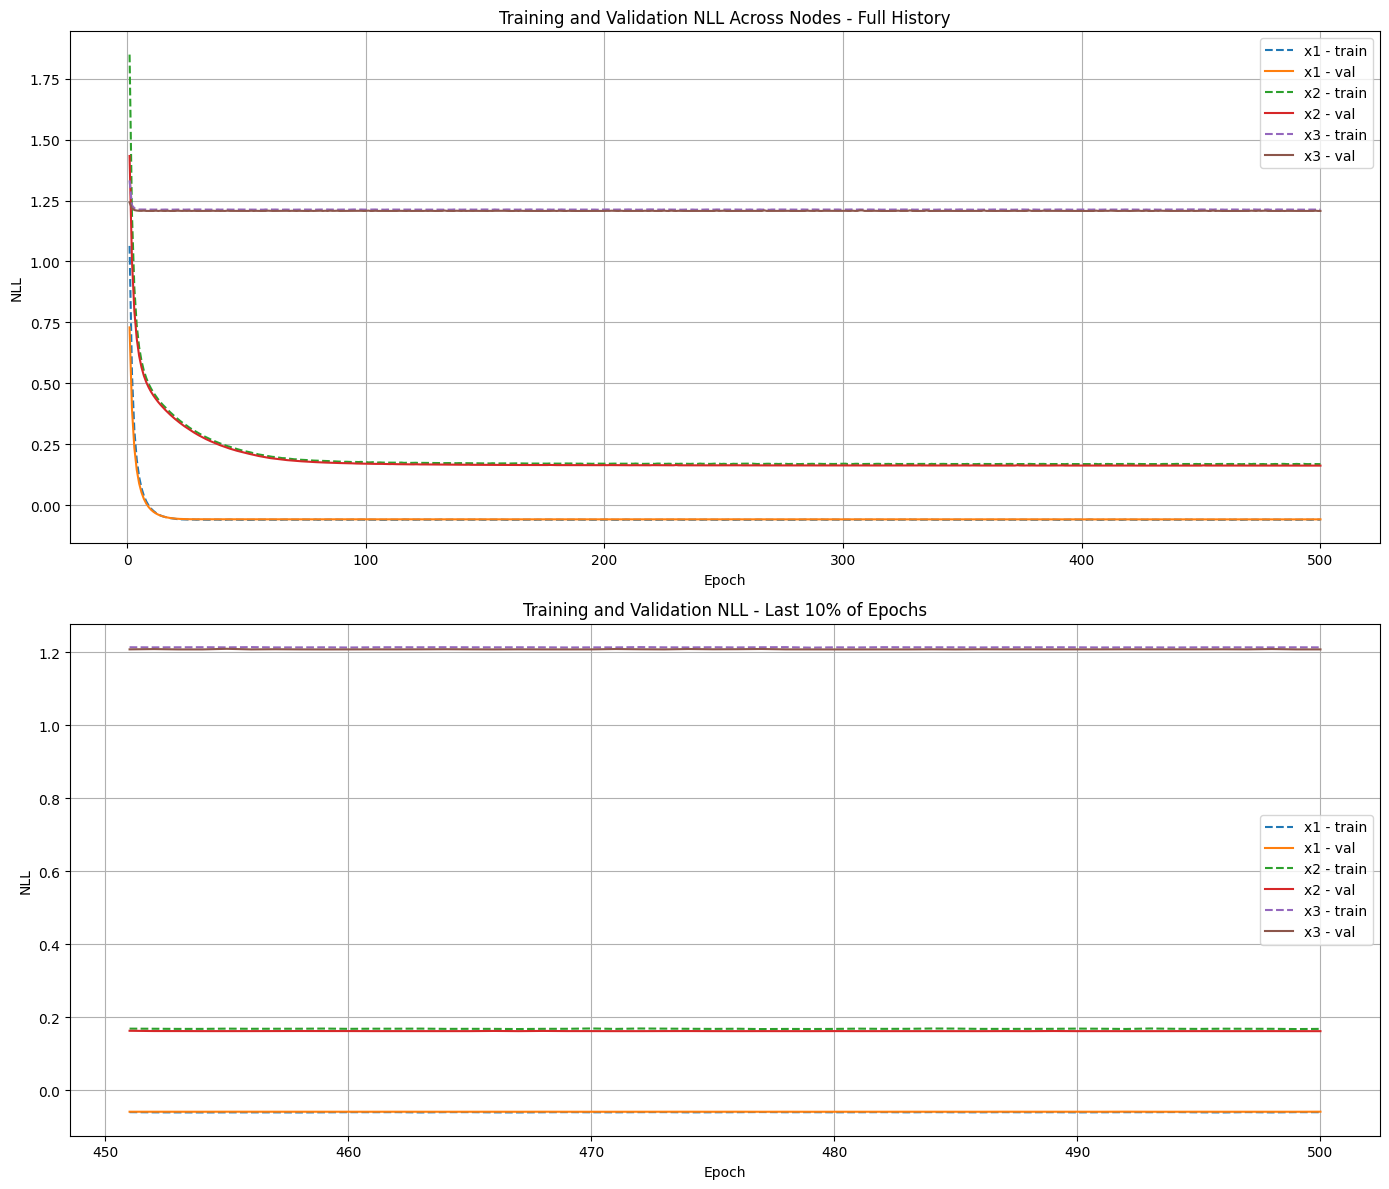

In [12]:
show_training_history(target_nodes,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--
[WARNING] target_col 'x1' not in DataFrame columns — is this intended for use as a Sampler?


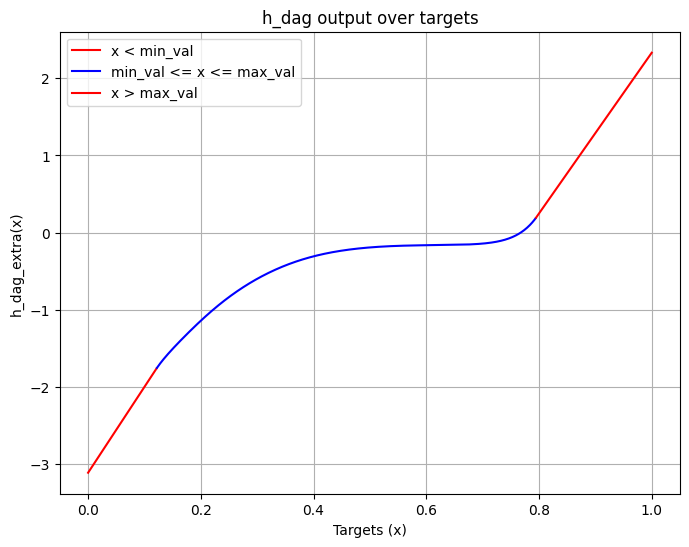


----*----------*-------------*--------Inspect TRAFO Node: x2 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance

----*----------*-------------*--------Inspect TRAFO Node: x3 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance


In [13]:
show_hdag_for_source_nodes(target_nodes,EXPERIMENT_DIR,device,xmin_plot=-0,xmax_plot=1)

----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


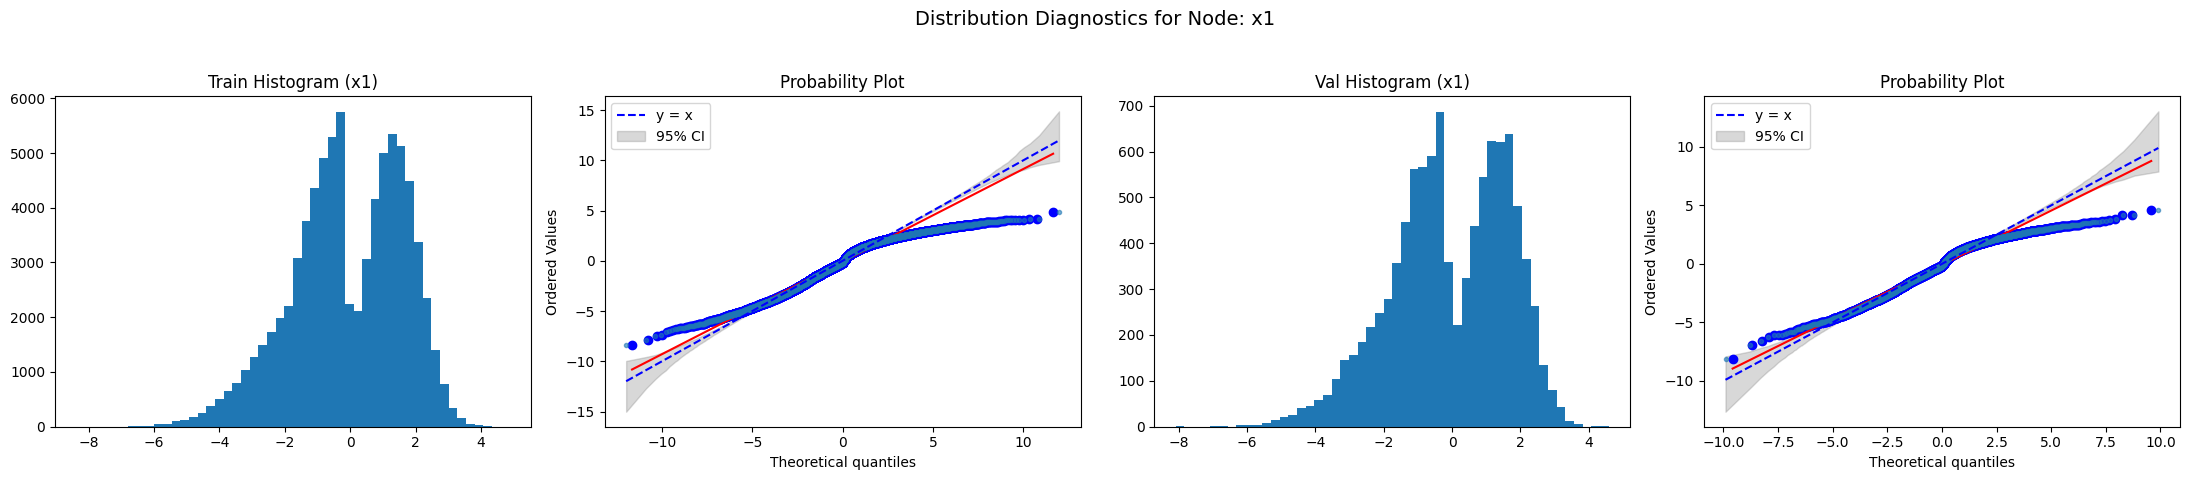

----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


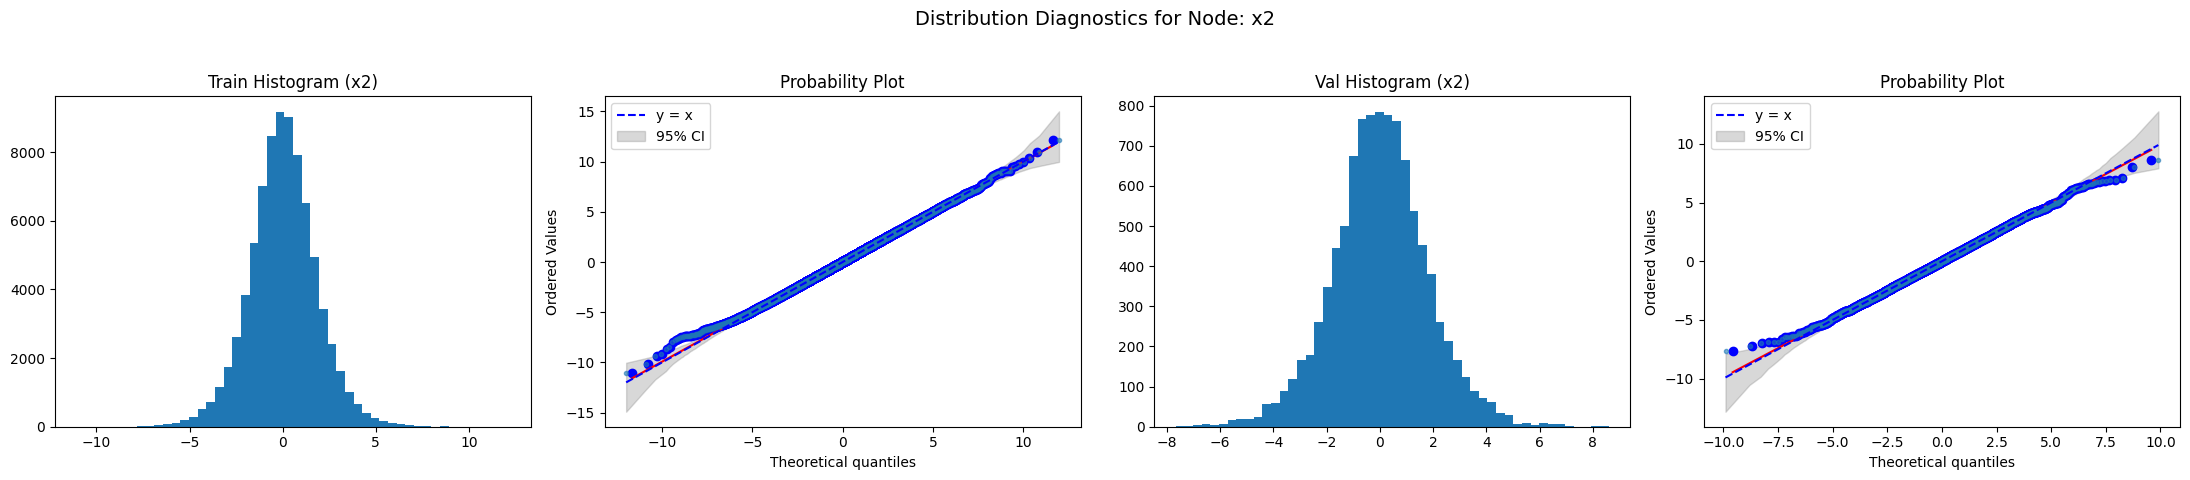

----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--
not defined for ordinal target variables


In [14]:


inspect_trafo_standart_logistic(target_nodes, EXPERIMENT_DIR, train_df, val_df, device, verbose=False)

### Coefficient estimates

In [15]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # enable 3D plotting

# --- Your existing setup ---
verbose    = False
batch_size = 4112
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# this x is only for overlaying your target curve in 2D plots
x1d = torch.linspace(-1, 1, steps=1000).unsqueeze(1).to(device)  # (1000, 1)
def f(x):
    return 0.75 * np.arctan(5 * (x + 0.12))

for node in target_nodes:
    print(f"\n---- check LS of {node} ----")
    if target_nodes[node]['node_type'] == 'source':
        print("Node type: source — skipping.")
        continue

    # load your model
    NODE_DIR   = os.path.join(EXPERIMENT_DIR, node)
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, target_nodes, verbose=verbose).to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()


    for i, module in enumerate(tram_model.nn_shift):
        name = module.__class__.__name__
        print(f"\nModule {i}: {name}")
        print(module)

        if name == 'LinearShift':
            print("  LinearShift weights:")
            print(module.fc.weight.data)
            continue

        # read wanted input dims
        in_feats = module.fc1.in_features
        print(f"  expects input shape = (batch_size, {in_feats})")

        # 2-input case → 3D surface plot
        if in_feats == 2:
            N = 100
            a = torch.linspace(-0, 2, steps=N, device=device)
            b = torch.linspace(-0, 2, steps=N, device=device)
            A, B = torch.meshgrid(a, b, indexing='ij')       # both (N, N)
            grid = torch.stack([A, B], dim=-1).view(-1, 2)   # (N*N, 2)

            with torch.no_grad():
                Y = module(grid).view(N, N).cpu().numpy()    # back to (N, N)

            A_np = A.cpu().numpy()
            B_np = B.cpu().numpy()

            fig = plt.figure()
            ax  = fig.add_subplot(111, projection='3d')
            ax.plot_surface(A_np, B_np, Y, cmap='viridis', edgecolor='none')
            ax.set_xlabel('input 1')
            ax.set_ylabel('input 2')
            ax.set_zlabel(f'{name}(x₁, x₂)')
            ax.set_title(f"{node} | Module {i}: {name} (3D surface)")
            plt.show()

        # 1-input case → 2D scatter
        else:
            N = 1000
            lin = torch.linspace(-1, 1, steps=N, device=device)
            dummy = lin.unsqueeze(1).repeat(1, in_feats)      # (N, in_feats)

            with torch.no_grad():
                y = module(dummy).squeeze().cpu().numpy()

            plt.figure()
            plt.scatter(dummy[:, 0].cpu().numpy(), y, s=5, label=f"{name} output")
            # overlay target
            plt.scatter(x1d.cpu().numpy(), -f(x1d.cpu().numpy()), c="red", s=5, label="target")
            plt.xlabel("input value")
            plt.ylabel("output value")
            plt.title(f"{node} | Module {i}: {name} (2D)")
            plt.legend()
            plt.show()



---- check LS of x1 ----
Node type: source — skipping.

---- check LS of x2 ----

Module 0: LinearShift
LinearShift(
  (fc): Linear(in_features=1, out_features=1, bias=False)
)
  LinearShift weights:
tensor([[1.3290]], device='cuda:0')

---- check LS of x3 ----

Module 0: LinearShift
LinearShift(
  (fc): Linear(in_features=1, out_features=1, bias=False)
)
  LinearShift weights:
tensor([[-0.1218]], device='cuda:0')

Module 1: LinearShift
LinearShift(
  (fc): Linear(in_features=1, out_features=1, bias=False)
)
  LinearShift weights:
tensor([[-1.2134]], device='cuda:0')


# 7. Sample from Graph

In [16]:
sample_full_dag(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={},
                            number_of_samples= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True,
                            debug=False)

[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/tramdag_paper_test_std/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/tramdag_paper_test_std/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/tramdag_paper_test_std/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[WARNING] target_col 'x1' not in DataFrame columns — is this intended for use as a Sampler?


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 330.59it/s]


[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[WARNING] target_col 'x2' not in DataFrame columns — is this intended for use as a Sampler?


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 323.61it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[WARNING] target_col 'x3' not in DataFrame columns — is this intended for use as a Sampler?


[INFO] Completed sampling for node 'x3'
[INFO] DAG sampling completed successfully for all nodes.


## 7.3 Inspect Sampling

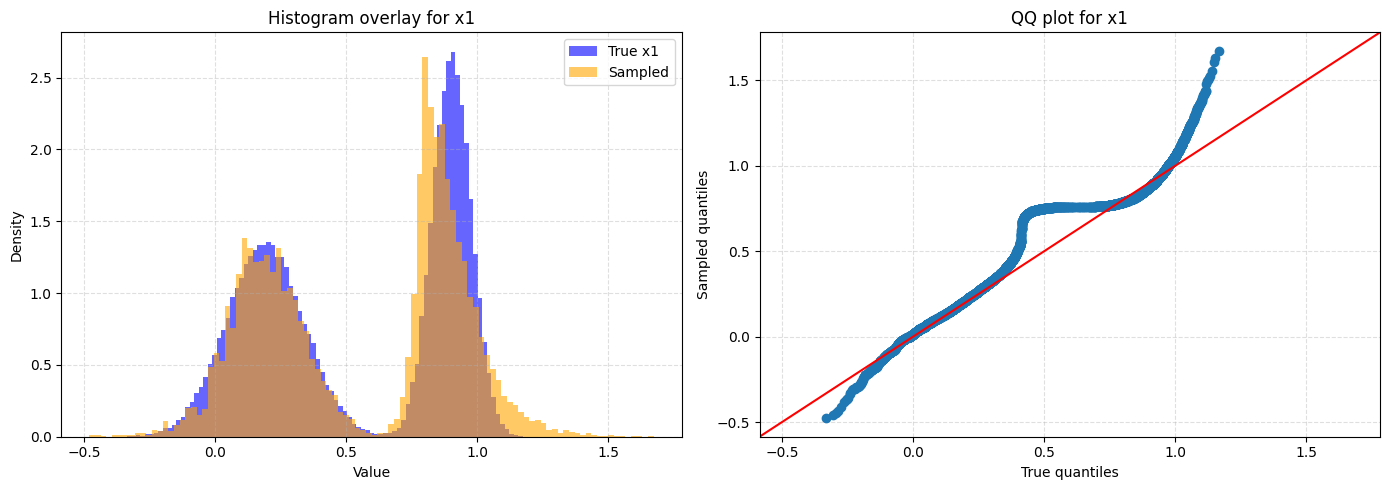

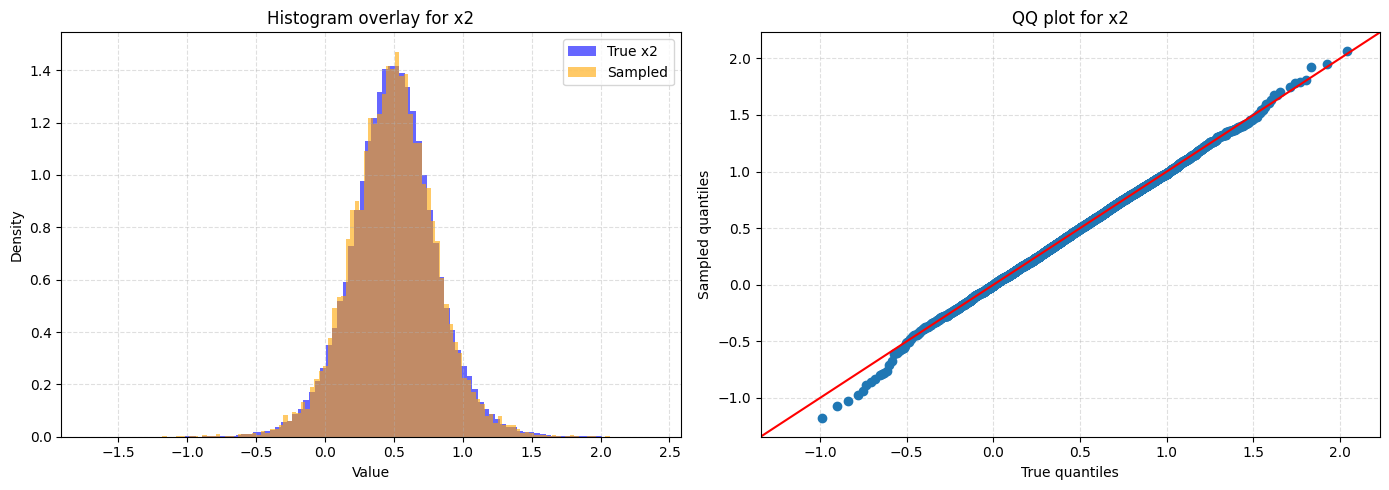

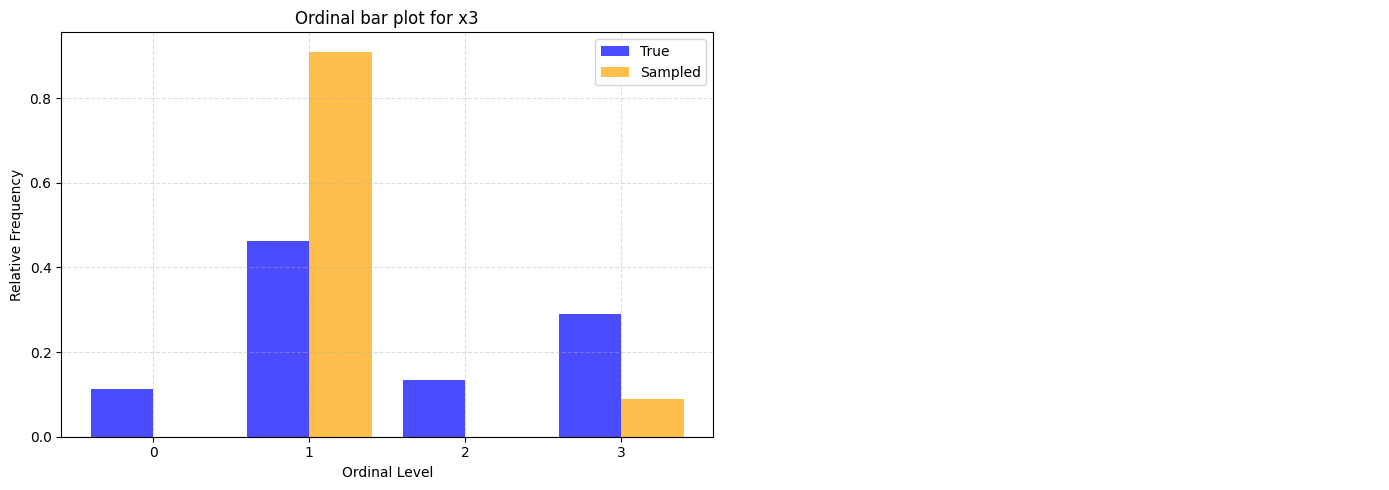

In [17]:
show_samples_vs_true(train_df,target_nodes,EXPERIMENT_DIR)

## 7.4 Intervention

In [ ]:
def f(x):
    return -0.3*x  

intervention_df=dgp(10_000, doX=[-1.0, None, None], seed=-1)
sns.pairplot(intervention_df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
sample_full_dag_chandru(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={'x1':-1.0},
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True)

In [ ]:
show_samples_vs_true(intervention_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')